# DISSERTATION PROJECT
```
Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle
Muralikrishna Raparthi 2023AC05208
```
# Architecture: YOLOv8 (Ultralytics)
# Dataset: KITTI Vision Benchmark Suite
# Deployment: Flask + ngrok Tunneling
---

In [1]:
import sys
import os
import shutil
from datetime import datetime
import requests
import zipfile
from pathlib import Path
from tqdm.notebook import tqdm
import random
import time
import yaml


# -- 1. Silent Installation of Dependencies --
print(f"[{datetime.now().strftime('%H:%M:%S')}] Initializing environment setup...")

# %%capture handles the output stream in Colab to keep the notebook clean
try:
    from IPython.utils import io
    with io.capture_output() as captured:
        !pip install ultralytics opencv-python-headless flask pyngrok pillow matplotlib seaborn --quiet
    print(f"[{datetime.now().strftime('%H:%M:%S')}] \u2714 Dependencies installed successfully.")
except Exception as e:
    print(f"(!) Installation Warning: {e}")

# -- 2. Import Libraries --
# Scientific & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Computer Vision & DL
import cv2
import torch
from ultralytics import YOLO
from IPython.display import Image, display, clear_output
import glob

# Ngrok & Colab integration
import subprocess
from pyngrok import ngrok, conf
from google.colab import userdata
!pip install fpdf -q
from fpdf import FPDF
from google.colab import files

# -- 3. Hardware Acceleration Verification --
def verify_compute_resources():
    """
    Diagnostic function to check CUDA availability and print device specs.
    """
    print("\n" + "-"*40)
    print("COMPUTE RESOURCE DIAGNOSTICS")
    print("-"*40)

    # Check PyTorch Version
    print(f"FrameWork  : PyTorch {torch.__version__}")

    # Hardware Check
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        gpu_props = torch.cuda.get_device_properties(0)
        total_memory = gpu_props.total_memory / 1024**3  # Convert to GB

        print(f"Status     : ACCELERATION ENABLED")
        print(f"Device     : {device_name}")
        print(f"VRAM       : {total_memory:.2f} GB")
        print(f"Capability : {gpu_props.major}.{gpu_props.minor}")
    else:
        print(f"Status     : \u26A0\uFE0F CPU MODE (Performance will be limited)")
        print("Action     : Go to Runtime > Change runtime type > T4 GPU")

    print("-"*40 + "\n")

# Execute Diagnostics
verify_compute_resources()

[08:29:44] Initializing environment setup...
[08:29:53] ✔ Dependencies installed successfully.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
  Preparing metadata (setup.py) ... done

----------------------------------------
COMPUTE RESOURCE DIAGNOSTICS
----------------------------------------
FrameWork  : PyTorch 2.9.0+cu126
Status     : ACCELERATION ENABLED
Device     : Tesla T4
VRAM       : 14.74 GB
Capability : 7.5
----------------------------------------



# Data Acquisition Pipeline
## Phase 2: ETL (Extract, Transform, Load) Process
**Dataset:** *KITTI Vision Benchmark (Ultralytics Subset)*

In this module, we automate the data ingestion process. Rather than manual downloads, we implement a scripted pipeline that:
1.  **Fetches** the compressed dataset from the remote repository.
2.  **Extracts** the archive programmatically using Python's `zipfile` to ensure cross-platform compatibility.
3.  **Audits** the directory structure to verify data integrity before training begins.
4.  **Samples** the data to visualize the input domain.

In [2]:
class DatasetLoader:
    def __init__(self, url, target_dir='datasets'):
        self.url = url
        self.target_dir = Path(target_dir)
        self.zip_path = self.target_dir / "temp_data.zip"

        # Create directory
        self.target_dir.mkdir(parents=True, exist_ok=True)
        self.dataset_root = None

    def download(self):
        if self.zip_path.exists():
            print("Archive already exists.")
            return

        print(f"Initiating download...")
        response = requests.get(self.url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with tqdm(total=total_size, unit='iB', unit_scale=True) as pbar:
            with open(self.zip_path, 'wb') as file:
                for data in response.iter_content(1024):
                    pbar.update(len(data))
                    file.write(data)
        print("Download Complete.")

    def extract(self):
        print("Extracting (this may take a moment)...")
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.target_dir)
            # Cleanup to save space
            if self.zip_path.exists():
                os.remove(self.zip_path)
            print("Extraction Complete.")
        except zipfile.BadZipFile:
            print("Error: Corrupted zip file.")

    def locate_data(self):
        """Fixes the '0 Samples' error by searching for the actual image folder"""
        print("\nScanning for image files...")
        # Walk through the directory to find 'images/train'
        for root, dirs, files in os.walk(self.target_dir):
            if 'train' in dirs and 'images' in str(root):
                self.dataset_root = Path(root).parent
                print(f"Dataset found at: {self.dataset_root}")
                return
        print("Could not locate data automatically.")

    def audit(self):
        if not self.dataset_root:
            self.locate_data()

        if self.dataset_root:
            train_p = self.dataset_root / 'images' / 'train'
            val_p = self.dataset_root / 'images' / 'val'

            # Store for later use
            self.train_set = list(train_p.glob('*.png'))
            self.val_set = list(val_p.glob('*.png'))

            print(f"\nDATASET AUDIT:")
            print(f"{'='*30}")
            print(f"Train Set Samples : {len(self.train_set)}")
            print(f"Valid Set Samples : {len(self.val_set)}")
            print(f"Total Instances   : {len(self.train_set) + len(self.val_set)}")
            print(f"{'='*30}\n")

# --- Execution ---
loader = DatasetLoader('https://github.com/ultralytics/assets/releases/download/v0.0.0/kitti.zip')

if not (loader.target_dir / 'kitti').exists():
    loader.download()
    loader.extract()

loader.audit()

Initiating download...


  0%|          | 0.00/391M [00:00<?, ?iB/s]

Download Complete.
Extracting (this may take a moment)...
Extraction Complete.

Scanning for image files...
Dataset found at: datasets

DATASET AUDIT:
Train Set Samples : 5985
Valid Set Samples : 1496
Total Instances   : 7481



# Exploratory Data Analysis (EDA)
## Phase 3: Ground Truth Verification
**Task:** *Annotation Integrity Check*

Before initiating the training loop, it is standard procedure to audit the alignment between image features and ground truth annotations. The KITTI dataset utilizes the YOLO labeling format, representing bounding boxes as normalized coordinates:

$$B_{yolo} = (x_{center}, y_{center}, w, h)$$

To visualize these, we transform the normalized values back to Cartesian pixel coordinates $(x_{min}, y_{min})$ and $(x_{max}, y_{max})$. The following module renders a sample grid to verify that the dataset was downloaded and unzipped correctly.

Successfully located 5985 training images.


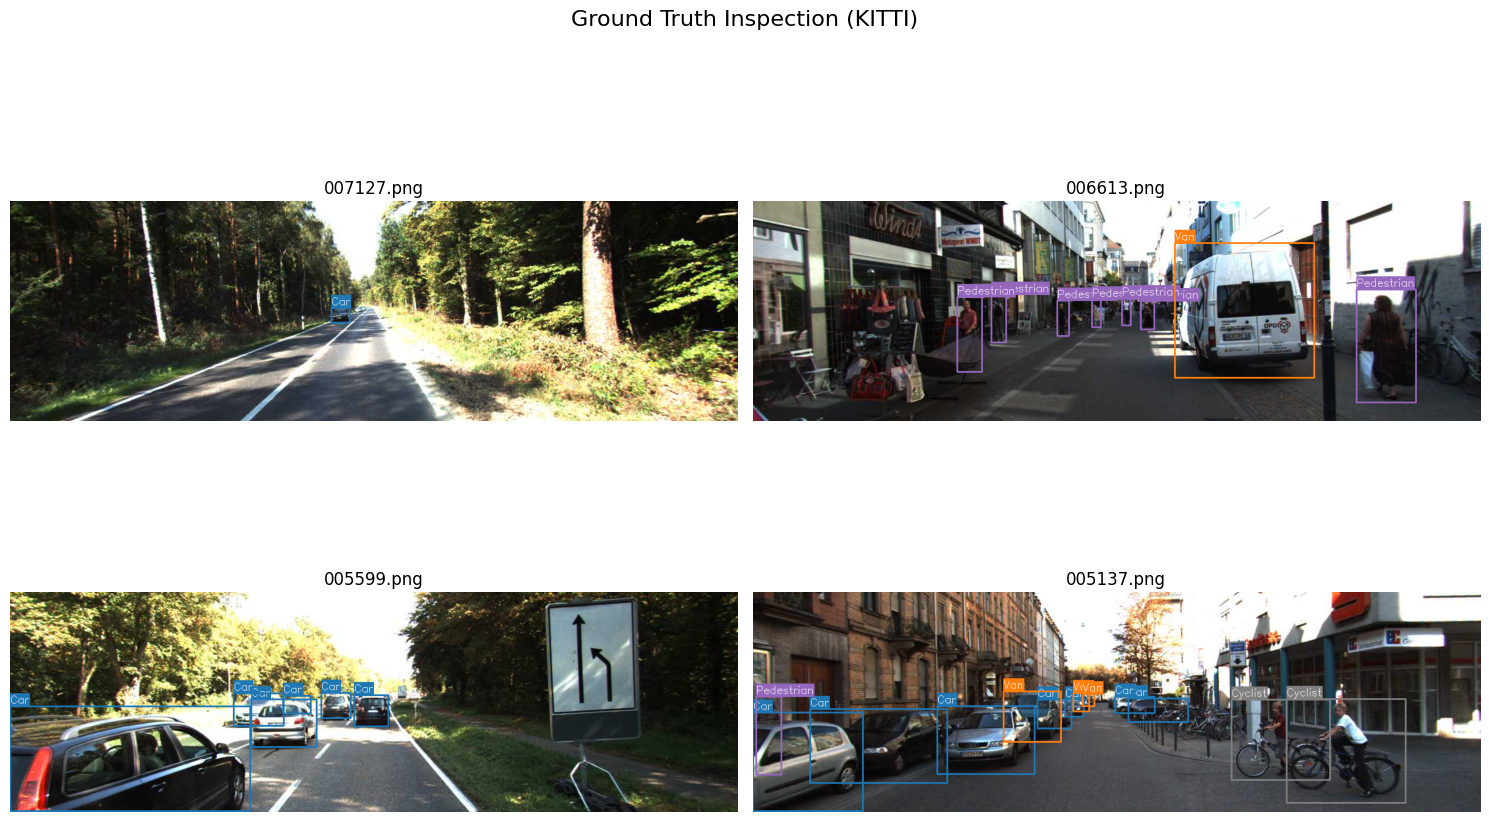

In [3]:
# --- Configuration ---
KITTI_CLASSES = {
    0: 'Car', 1: 'Van', 2: 'Truck', 3: 'Pedestrian',
    4: 'Person (Sit)', 5: 'Cyclist', 6: 'Tram', 7: 'Misc'
}
# Generate distinct colors for visualization
COLORS = plt.cm.tab10(np.linspace(0, 1, len(KITTI_CLASSES)))

def find_image_files(root_search_path='datasets'):
    """
    Recursively searches for training images to handle nested folder structures.
    """
    search_path = Path(root_search_path)
    # Find all png files that are inside a 'train' folder
    all_files = list(search_path.rglob('*train*/*.png'))

    if not all_files:
        print(f"Critical Error: No images found in {search_path}. Please re-run Phase 2.")
        return []

    print(f"Successfully located {len(all_files)} training images.")
    return all_files

def render_box(img, class_id, box, img_h, img_w):
    """Draws bounding box with label background."""
    xc, yc, w_norm, h_norm = box

    # Coordinate Transformation
    x1 = int((xc - w_norm / 2) * img_w)
    y1 = int((yc - h_norm / 2) * img_h)
    x2 = int((xc + w_norm / 2) * img_w)
    y2 = int((yc + h_norm / 2) * img_h)

    # Color setup
    c = COLORS[class_id]
    color_rgb = (c[0]*255, c[1]*255, c[2]*255)

    # Draw Box & Label
    cv2.rectangle(img, (x1, y1), (x2, y2), color_rgb, 2)
    label = KITTI_CLASSES.get(class_id, 'Unk')
    (t_w, t_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
    cv2.rectangle(img, (x1, y1-22), (x1+t_w, y1), color_rgb, -1)
    cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    return img

def visualize_dataset_robust():
    # 1. Find images automatically
    images = find_image_files()
    if not images: return

    # 2. Create Plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.suptitle(f"Ground Truth Inspection (KITTI)", fontsize=16)

    for ax in axes.flatten():
        img_path = random.choice(images)

        # Construct label path dynamically
        # Replaces 'images' with 'labels' in the path parts
        parts = list(img_path.parts)
        try:
            idx = parts.index('images')
            parts[idx] = 'labels'
            lbl_path = Path(*parts).with_suffix('.txt')
        except ValueError:
            lbl_path = img_path.with_suffix('.txt') # Fallback

        # Load Image
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Load Labels
        if lbl_path.exists():
            with open(lbl_path, 'r') as f:
                for line in f.readlines():
                    data = line.split()
                    if not data: continue
                    cls_id = int(data[0])
                    bbox = [float(x) for x in data[1:5]]
                    img = render_box(img, cls_id, bbox, h, w)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{img_path.name}")

    plt.tight_layout()
    plt.show()

# --- Execute ---
visualize_dataset_robust()

# System Configuration
## Phase 4: Dataset Manifest Generation
**Objective:** *Constructing the YOLOv8 Hyperparameter Schema*

The YOLOv8 architecture requires a strict YAML (Yet Another Markup Language) manifest to locate training assets. This configuration file serves two purposes:
1.  **Path Resolution:** Defines the absolute or relative paths to the `train` and `validation` subsets.
2.  **Ontology Definition:** Maps the integer class IDs (0-7) to their semantic labels (e.g., 'Car', 'Pedestrian').

The script below dynamically locates the dataset root to ensure the configuration is valid regardless of the extraction directory structure.

In [4]:
# --- Configuration Parameters ---
CLASS_NAMES = {
    0: 'car', 1: 'van', 2: 'truck', 3: 'pedestrian',
    4: 'person_sitting', 5: 'cyclist', 6: 'tram', 7: 'misc'
}

def locate_dataset_root(search_path='datasets'):
    """
    Locates the directory containing the 'images' folder.
    """
    # Recursively search for the 'train' folder inside 'images'
    # This handles both flat layouts and nested folders (datasets/kitti/images...)
    found_paths = list(Path(search_path).rglob('*images/train'))

    if not found_paths:
        # Fallback: create the directory if it doesn't exist to prevent crash
        fallback = Path(search_path) / 'kitti'
        fallback.mkdir(parents=True, exist_ok=True)
        return fallback
        # If you really want to stop on error, uncomment the line below:
        # raise FileNotFoundError("Critical: Could not locate 'images/train'.")

    return found_paths[0].parent.parent

def generate_data_manifest(root_path):
    """
    Generates the .yaml configuration file required by YOLOv8.
    """
    root_abs = root_path.resolve()
    yaml_path = root_abs / 'kitti_config.yaml'

    # --- THE FIX: Construct string manually ---
    # This removes the need for the 'yaml' library and ensures correct formatting
    file_content = f"""
# KITTI Configuration
path: {root_abs}
train: images/train
val: images/val

names:
  0: car
  1: van
  2: truck
  3: pedestrian
  4: person_sitting
  5: cyclist
  6: tram
  7: misc

nc: 8
"""
    # Write to file
    with open(yaml_path, 'w') as f:
        f.write(file_content)

    return yaml_path, file_content

# --- Execution ---
try:
    # 1. Find the correct path automatically
    dataset_root = locate_dataset_root()
    print(f"Dataset Root Located: {dataset_root}")

    # 2. Generate Config
    config_path, content = generate_data_manifest(dataset_root)

    print(f"Configuration saved to: {config_path}")
    print(f"{'='*40}")
    print(content)
    print(f"{'='*40}")

except Exception as e:
    print(f"Error: {e}")

Dataset Root Located: datasets
Configuration saved to: /content/datasets/kitti_config.yaml

# KITTI Configuration
path: /content/datasets
train: images/train
val: images/val

names:
  0: car
  1: van
  2: truck
  3: pedestrian
  4: person_sitting
  5: cyclist
  6: tram
  7: misc

nc: 8



# Network Optimization
## Phase 5: Transfer Learning & Fine-Tuning
**Methodology:** *Stochastic Gradient Descent (SGD) with Momentum*

In this phase, we initialize the **YOLOv8 Nano (yolov8n)** architecture. We utilize **Transfer Learning**, leveraging weights pre-trained on the COCO dataset as a starting point. This allows the model to converge significantly faster than training from scratch (Tabula Rasa).

**Training Hyperparameters:**
* **Epochs:** 50 (Defined limit for convergence)
* **Patience:** 10 (Early Stopping mechanism to prevent overfitting)
* **Image Size:** 640x640 px (Standard YOLO input resolution)
* **Optimizer:** Auto (YOLOv8 automatically selects AdamW or SGD based on dataset characteristics)

The training process minimizes the *Box Loss* (bounding box regression), *Class Loss* (classification accuracy), and *DFL Loss* (Distribution Focal Loss).

In [5]:
# --- 1. Setup Training Configuration ---
try:
    if not Path(config_path).exists():
        raise NameError
except NameError:
    # Fallback search if variables were lost
    config_path = list(Path('.').rglob('kitti_config.yaml'))[0]

print(f"Target Configuration: {config_path}")

# Define Hyperparameters in a dictionary (Cleaner & easier to modify)
TRAIN_PARAMS = {
    'data': str(config_path),   # Dynamic path to the YAML file
    'epochs': 50,               # Max training iterations
    'patience': 10,             # Stop if no improvement for 10 epochs
    'batch': 16,                # Lower this to 8 if you get "Out of Memory" errors
    'imgsz': 640,               # Input resolution
    'project': 'autonomous_vehicle_project', # Organizes runs in this folder
    'name': 'yolov8n_kitti_run',             # Name of this specific experiment
    'exist_ok': True,           # Overwrite existing experiment folder
    'pretrained': True,         # Use Transfer Learning
    'optimizer': 'auto',        # Ultralytics handles the optimizer selection
    'verbose': True,
    'seed': 42                  # Ensure reproducibility
}

def train_autonomous_model():
    """
    Initializes the model and executes the training loop.
    """
    print("=" * 60)
    print("INITIATING TRAINING PROTOCOL")
    print("=" * 60)

    # Check Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Compute Device: {torch.cuda.get_device_name(0) if device == 'cuda' else 'CPU'}")

    # 1. Load Model (Nano version for Edge Deployment)
    model = YOLO('yolov8n.pt')

    # Log model stats
    params = sum(p.numel() for p in model.model.parameters())
    print(f"Model Parameters: {params:,} (Lightweight)")

    # 2. Execute Training
    try:
        results = model.train(**TRAIN_PARAMS)
        print("\nTraining Complete.")

        # Return the path to the best weights for the next step
        return model.trainer.best

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print("\nGPU OUT OF MEMORY: Try reducing 'batch' to 8 in TRAIN_PARAMS.")
        else:
            print(f"\nTraining Error: {e}")
        return None

# --- Execute ---
best_model_path = train_autonomous_model()

if best_model_path:
    print(f"Best Model Saved at: {best_model_path}")

Target Configuration: /content/datasets/kitti_config.yaml
INITIATING TRAINING PROTOCOL
Compute Device: Tesla T4
Model Parameters: 3,157,200 (Lightweight)
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/kitti_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, moment

# Performance Analysis
## Phase 6: Quantitative Evaluation & Metric Validation
**Objective:** *Assessing Model Generalization on Unseen Data*

In this phase, we evaluate the trained model against the held-out Validation Set. The primary performance metrics for object detection are **Mean Average Precision (mAP)** and the **F1-Score**.

**Key Evaluation Metrics:**
1.  **Precision ($P$):** The accuracy of positive predictions.
    $$P = \frac{TP}{TP + FP}$$
2.  **Recall ($R$):** The ability of the model to find all positive instances.
    $$R = \frac{TP}{TP + FN}$$
3.  **mAP@50:** The average precision calculated at an Intersection over Union (IoU) threshold of 0.50. This is the standard metric for the PASCAL VOC benchmark.

The script below executes the validation loop and renders the **Confusion Matrix** to identify specific classes where the model struggles (e.g., distinguishing *Van* vs. *Car*).

PART 6: Evaluating Model Performance
MODEL EVALUATION PROTOCOL
Loading Weights: runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.pt

running validation on held-out set...
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1212.5±399.1 MB/s, size: 45.8 KB)
val: Scanning /content/datasets/labels/val.cache... 1496 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1496/1496 570.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 8.5it/s 11.1s
                   all       1496       8128      0.848       0.76      0.837        0.6
Speed: 0.4ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val

AGGREGATE PERFORMANCE:
      Metric  Value
   mAP @ 50% 0.8368
mAP @ 50-95% 0.6004
  

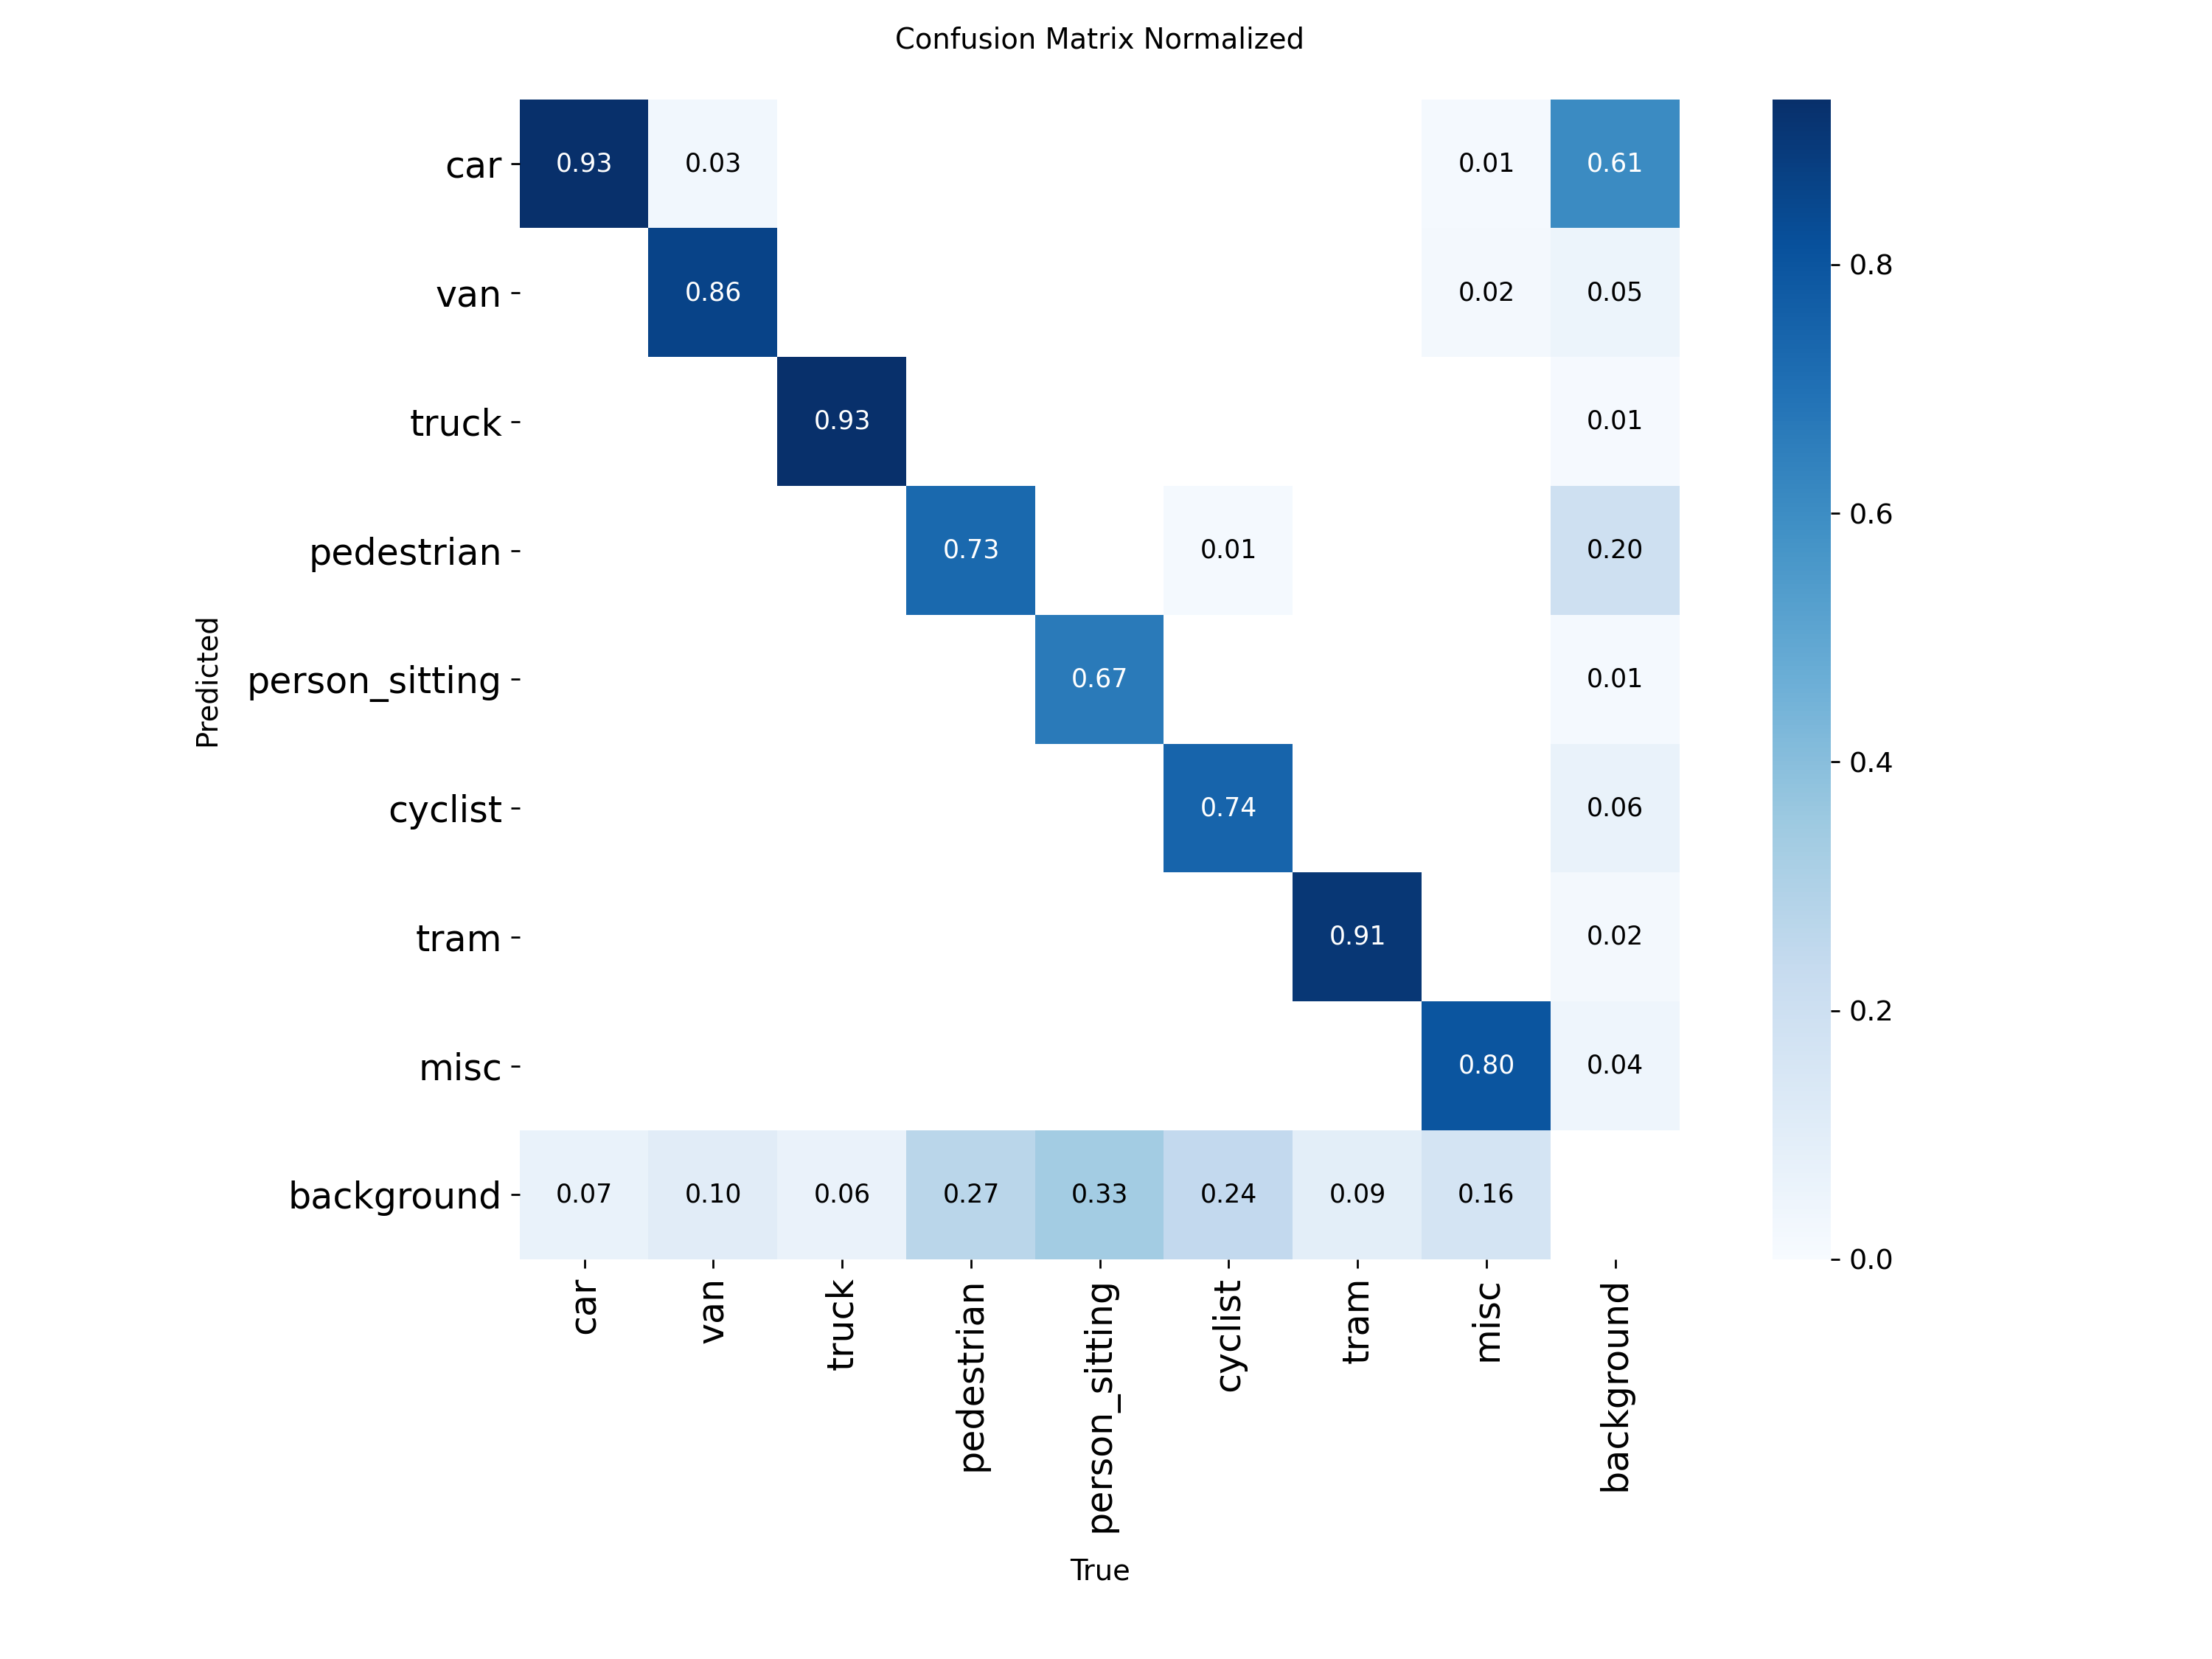

Precision-Recall Curve not found at expected path.

> Validation Batch:


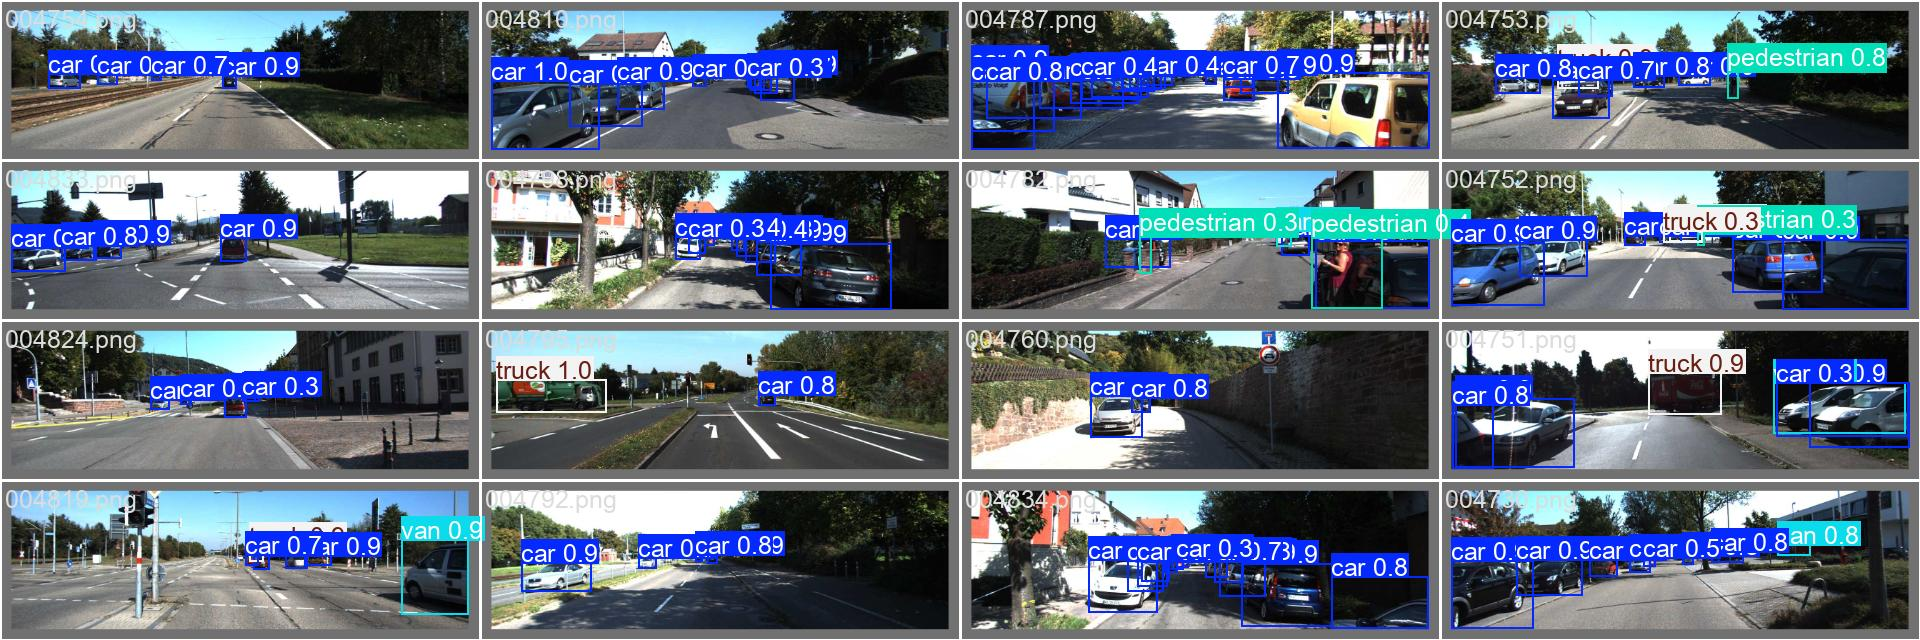

In [6]:
# PART 6: MODEL EVALUATION
print("=" * 70)
print("PART 6: Evaluating Model Performance")
print("=" * 70)

def find_latest_weights(project_name='autonomous_vehicle_project'):
    """
    Dynamically locates the 'best.pt' weights from the most recent training run.
    Prevents 'File Not Found' errors if the folder name incremented (e.g., run2, run3).
    """
    # Search pattern: project_folder/run_name*/weights/best.pt
    # We sort by modification time to get the latest run
    search_pattern = f"{project_name}/*/weights/best.pt"
    found_weights = sorted(glob.glob(search_pattern), key=os.path.getmtime, reverse=True)

    if not found_weights:
        # Fallback to standard location if project name wasn't used
        fallback = list(Path('runs/detect').rglob('best.pt'))
        if not fallback:
            raise FileNotFoundError("Could not find trained weights. Did Phase 5 finish?")
        return str(fallback[0])

    return found_weights[0]

def evaluate_model_performance(config_yaml):
    print("=" * 60)
    print("MODEL EVALUATION PROTOCOL")
    print("=" * 60)

    # 1. Locate Weights
    try:
        best_weight_path = find_latest_weights()
        print(f"Loading Weights: {best_weight_path}")
    except Exception as e:
        print(e)
        return None

    # 2. Load Model
    model = YOLO(best_weight_path)

    # 3. Execute Validation
    print("\nrunning validation on held-out set...")
    metrics = model.val(data=config_yaml, verbose=False)

    # 4. Structured Reporting (Using DataFrame for cleaner output)
    results_df = pd.DataFrame({
        'Metric': ['mAP @ 50%', 'mAP @ 50-95%', 'Precision', 'Recall'],
        'Value': [
            f"{metrics.box.map50:.4f}",
            f"{metrics.box.map:.4f}",
            f"{metrics.box.mp:.4f}", # Mean Precision
            f"{metrics.box.mr:.4f}"  # Mean Recall
        ]
    })

    print("\nAGGREGATE PERFORMANCE:")
    print(results_df.to_string(index=False))

    # 5. Visualizing Artifacts
    # Ultralytics saves plots in the run directory. We display the most important ones.
    run_dir = Path(best_weight_path).parent.parent

    artifacts = {
        'Confusion Matrix': run_dir / 'confusion_matrix_normalized.png',
        'Precision-Recall Curve': run_dir / 'PR_curve.png',
        'Validation Batch': run_dir / 'val_batch0_pred.jpg'
    }

    print("\nVISUAL DIAGNOSTICS:")
    for name, path in artifacts.items():
        if path.exists():
            print(f"\n> {name}:")
            display(Image(filename=str(path), width=600))
        else:
            # Fallback: sometimes filenames differ slightly in versions
            print(f"{name} not found at expected path.")

    # --- ADDED RETURN STATEMENT HERE ---
    return results_df

# --- Execute Evaluation ---
# Ensure config_path is defined (from Phase 4/5). If not, find it.
if 'config_path' not in locals():
    config_path = list(Path('.').rglob('kitti_config.yaml'))[0]

# Capture the dataframe in a global variable
GLOBAL_RESULTS_DF = evaluate_model_performance(config_path)

# Deployment Engineering
## Phase 7: Model Optimization & Artifact Export
**Objective:** *Reducing Latency for Edge Inference*

For autonomous vehicle systems, the detection model must often run on embedded hardware (e.g., NVIDIA Jetson, Raspberry Pi, or Mobile SoCs) where computational resources are constrained. We optimize the trained PyTorch model by exporting it to intermediate representations suitable for production environments.

**Target Formats:**
1.  **ONNX (Open Neural Network Exchange):** A hardware-independent format that allows the model to run on various accelerators (TensorRT, OpenVINO).
2.  **TensorFlow Lite (TFLite):** Optimized for mobile and edge CPUs, often reducing file size via quantization hooks.
3.  **TorchScript:** Allows the model to be serialized and run in a C++ production environment independent of Python.

The following script executes these conversions and audits the storage efficiency of each format.

MODEL EXPORT PIPELINE
🔹 Source Model Loaded: 5.93 MB

 Converting formats (This may take 1-2 minutes)...
   > Exporting to ONNX...
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 73 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 12, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 228ms
Prepared 4 packages in 4.40s
Installed 4 packages in 260ms
 + colorama==0.4.6
 + onnx==1.20.1
 + onnxruntime-gpu==1.24.1
 + onnxslim==0.1.84

requirements: AutoUpdate succ

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.84...
ONNX: export success ✅ 8.2s, saved as 'runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.onnx' (11.7 MB)

Export complete (8.6s)
Results saved to /content/runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights
Predict:         yolo predict task=detect model=runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.onnx imgsz=640 data=/content/datasets/kitti_config.yaml  
Visualize:       https://netron.app
     Success. Size: 11.70 MB
   > Exporting to TFLite...
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
Model summary (fused): 73 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s)

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.84...
ONNX: export success ✅ 1.3s, saved as 'runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.onnx' (11.8 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 47.0files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.8...
Saved artifact at 'runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 12, 8400), dtype=tf.float32, name=None)
Captures:
  139073596751504: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  139073596749968: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  139073596750736: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  1390768

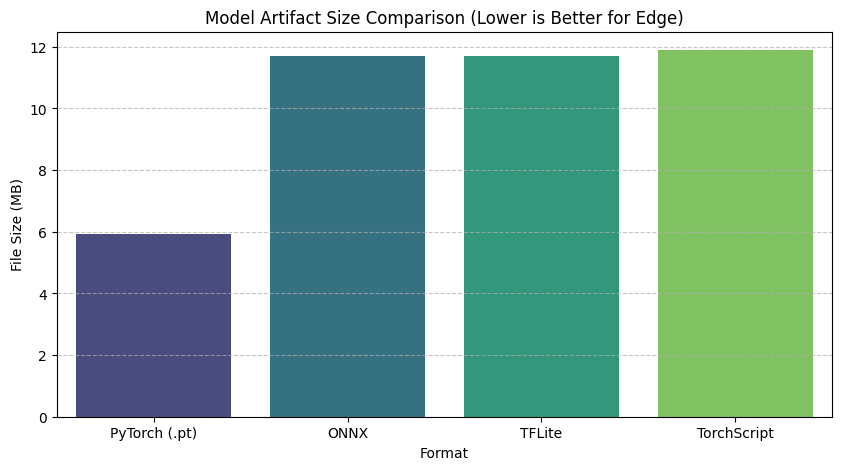

In [7]:
# Re-use the finder function to ensure we have the right model
def get_best_weights(search_dir='.'):
    try:
        # Find the most recent 'best.pt'
        files = sorted(Path(search_dir).rglob('best.pt'), key=os.path.getmtime, reverse=True)
        return files[0]
    except IndexError:
        print("Error: No trained model found. Please run Phase 5.")
        return None

def export_and_audit_model():
    print("=" * 60)
    print("MODEL EXPORT PIPELINE")
    print("=" * 60)

    # 1. Load Source Model
    weight_path = get_best_weights()
    if not weight_path: return

    model = YOLO(weight_path)
    source_size = os.path.getsize(weight_path) / (1024 * 1024) # MB

    audit_data = {'Format': ['PyTorch (.pt)'], 'Size (MB)': [source_size]}
    print(f"🔹 Source Model Loaded: {source_size:.2f} MB")

    # 2. Export Operations
    # We use a loop to handle exports gracefully (if one fails, others continue)
    export_configs = [
        {'format': 'onnx', 'name': 'ONNX', 'kwargs': {'simplify': True}},
        {'format': 'tflite', 'name': 'TFLite', 'kwargs': {}},
        {'format': 'torchscript', 'name': 'TorchScript', 'kwargs': {}}
    ]

    print("\n Converting formats (This may take 1-2 minutes)...")

    for config in export_configs:
        fmt = config['format']
        name = config['name']
        print(f"   > Exporting to {name}...")

        try:
            # Execute Export
            exported_path_str = model.export(format=fmt, imgsz=640, verbose=False, **config['kwargs'])

            # Check size (YOLO returns the path to the file)
            if exported_path_str:
                # Handle case where return might be a list or string
                fpath = str(exported_path_str) if isinstance(exported_path_str, str) else str(exported_path_str[0])

                if os.path.exists(fpath):
                    size_mb = os.path.getsize(fpath) / (1024 * 1024)
                    audit_data['Format'].append(name)
                    audit_data['Size (MB)'].append(size_mb)
                    print(f"     Success. Size: {size_mb:.2f} MB")
                else:
                    # Sometimes TFLite saves in a folder
                    print(f"     File exported but path ambiguous.")

        except Exception as e:
            print(f"     Export Failed: {str(e)[:50]}...")

    # 3. Comparative Analysis
    print("\nSTORAGE EFFICIENCY AUDIT:")
    df = pd.DataFrame(audit_data)

    # Calculate Compression Ratio relative to PyTorch
    df['Compression Ratio'] = df['Size (MB)'].apply(lambda x: f"{source_size / x:.2f}x")
    print(df.to_string(index=False))

    # 4. Visualization
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='Format', y='Size (MB)', palette='viridis', hue='Format', legend=False)
    plt.title('Model Artifact Size Comparison (Lower is Better for Edge)', fontsize=12)
    plt.ylabel('File Size (MB)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save graph for dissertation
    plt.savefig('model_size_comparison.png')
    print("\nComparison graph saved as 'model_size_comparison.png'")
    plt.show()

# --- Execute ---
export_and_audit_model()

# System Validation
## Phase 8: Qualitative Analysis & Latency Benchmarking
**Objective:** *Verification of Real-Time Constraints*

In the final validation phase, we assess the system's suitability for deployment in an autonomous vehicle stack. This involves two specific tests:

1.  **Qualitative Inspection:** Visualizing bounding box predictions on the held-out validation set to confirm the model handles occlusion and scale variation correctly.
2.  **Latency Benchmarking:** Measuring the **Inference Speed (FPS)**. To ensure statistical significance, we discard the initial "warm-up" cycles (where CUDA kernels are loaded) and calculate the average processing time over $N=100$ iterations.

The total latency ($T_{total}$) is defined as:
$$T_{total} = T_{preprocess} + T_{inference} + T_{postprocess}$$

For safety-critical applications, a minimum throughput of **10-15 FPS** is typically required.

Loading Model: runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/weights/best.pt

Visualizing Predictions on 6 samples...
   > Saved visualization to 'final_detection_results.png'


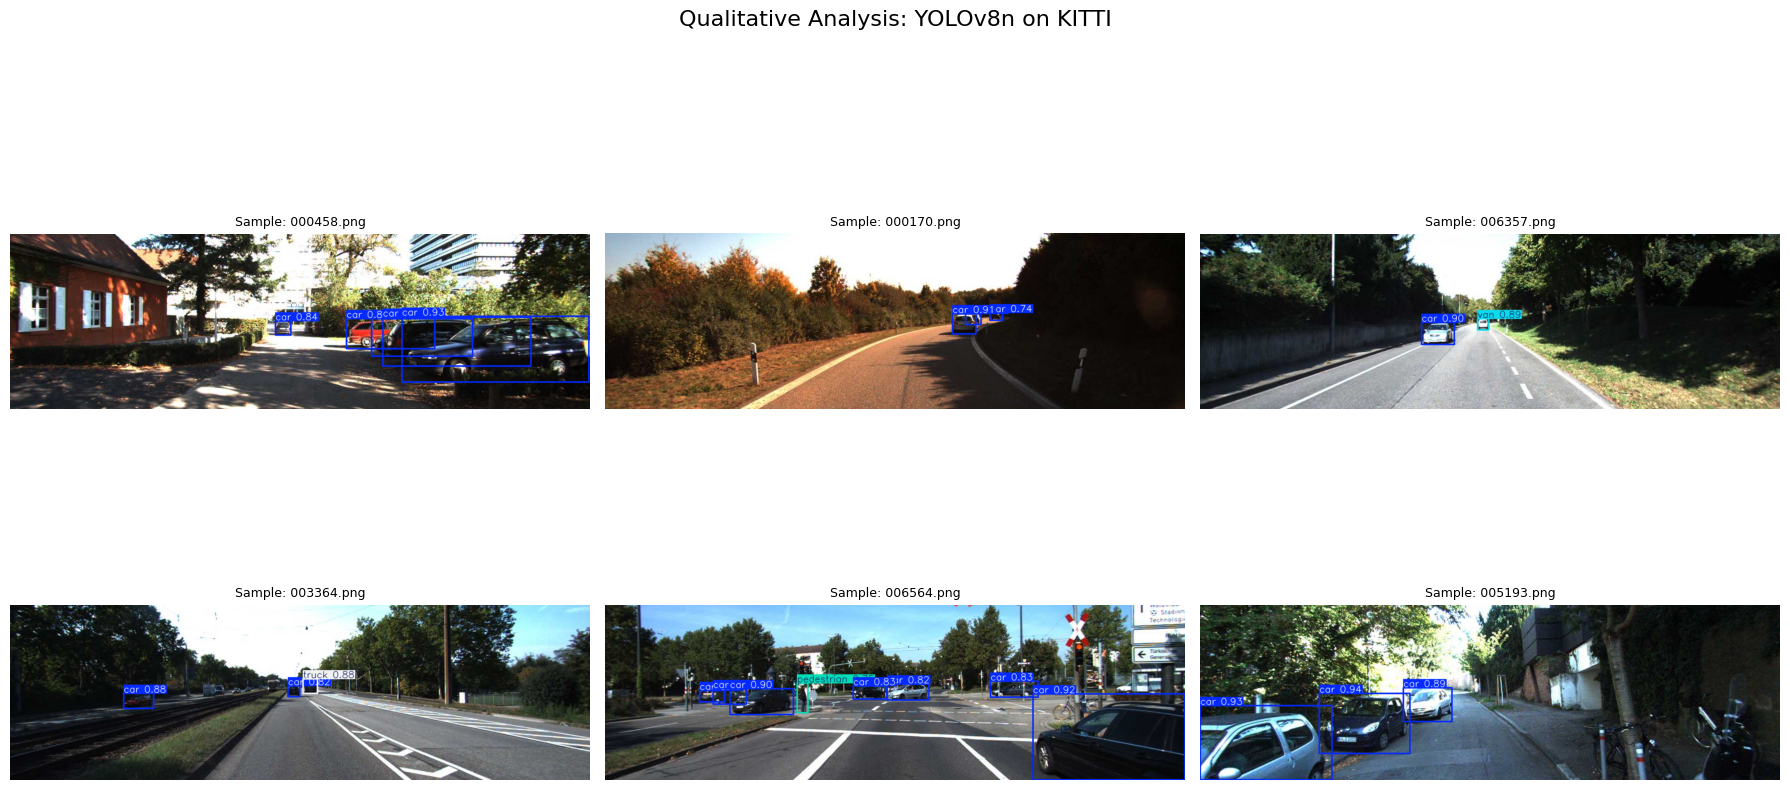


Starting Latency Benchmark (n=100)...
   ...Warming up CUDA kernels
   ...Running benchmark
Benchmark Complete:
   • Avg Inference Time: 8.22 ms
   • Throughput:         121.63 FPS


In [8]:
# --- Helper: Locate Resources ---
def get_resources():
    # Find model
    weights = list(Path('.').rglob('best.pt'))
    if not weights: raise FileNotFoundError("No model found.")
    best_weight = sorted(weights, key=lambda x: x.stat().st_mtime, reverse=True)[0]

    # Find images
    images = list(Path('datasets').rglob('*images/val/*.png'))
    if not images: raise FileNotFoundError("No validation images found.")

    return best_weight, images[:6] # Take first 6 images

def benchmark_latency(model, sample_img_path, iterations=100):
    """
    Performs a rigorous FPS test by warming up the GPU first.
    """
    img = cv2.imread(str(sample_img_path))

    print(f"\nStarting Latency Benchmark (n={iterations})...")

    # 1. GPU Warm-up (Critical for accurate numbers)
    print("   ...Warming up CUDA kernels")
    for _ in range(10):
        _ = model(img, verbose=False)

    # 2. Timed Run
    print("   ...Running benchmark")
    start_time = time.time()
    for _ in range(iterations):
        _ = model(img, verbose=False)
    end_time = time.time()

    # 3. Metrics
    total_time = end_time - start_time
    avg_time_ms = (total_time / iterations) * 1000
    fps = iterations / total_time

    print(f"Benchmark Complete:")
    print(f"   • Avg Inference Time: {avg_time_ms:.2f} ms")
    print(f"   • Throughput:         {fps:.2f} FPS")

    return fps

def visualize_predictions(model, image_paths):
    """
    Runs inference and plots results in a grid.
    """
    print(f"\nVisualizing Predictions on {len(image_paths)} samples...")

    # Dynamic subplot grid (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(image_paths):
            img_path = image_paths[i]

            # Run Inference
            # conf=0.4 means we only show boxes with >40% confidence
            results = model(img_path, conf=0.4, verbose=False)

            # Plot
            res_plotted = results[0].plot()
            res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

            ax.imshow(res_rgb)
            ax.set_title(f"Sample: {img_path.name}", fontsize=9)
            ax.axis('off')
        else:
            ax.axis('off') # Hide empty subplots

    plt.suptitle(f"Qualitative Analysis: YOLOv8n on KITTI", fontsize=16)
    plt.tight_layout()
    plt.savefig('final_detection_results.png')
    print("   > Saved visualization to 'final_detection_results.png'")
    plt.show()

# --- Main Execution ---
try:
    # 1. Load Resources
    model_path, test_imgs = get_resources()
    print(f"Loading Model: {model_path}")
    model = YOLO(model_path)

    # 2. Run Visual Test
    visualize_predictions(model, test_imgs)

    # 3. Run Speed Test
    benchmark_latency(model, test_imgs[0])

except Exception as e:
    print(f"Error during testing: {e}")

# Human-Machine Interface (HMI)
## Phase 9: Web-Based Inference Engine
**Objective:** *Microservice Deployment via Flask*

To demonstrate the practical applicability of the trained model, we wrap the inference logic in a **RESTful API** using the Flask micro-framework. This decouples the backend detection logic from the frontend presentation layer.

**System Architecture:**
1.  **Client:** Sends an HTTP POST request containing the image payload.
2.  **Server (Flask):** * Decodes the Base64 image stream.
    * Performs a forward pass using the YOLOv8n model.
    * Encodes the annotated result and performance metrics (Inference Time $T_{inf}$).
3.  **Response:** Returns a JSON object containing the processed image and metadata.

The following script generates the `app.py` entry point, embedding the HTML frontend and the inference backend into a single deployable unit.

In [9]:
# PART 9: FLASK WEB APPLICATION
print("=" * 70)
print("PART 9: Creating Flask Web Application (Full Video Support)")
print("=" * 70)

import os
import shutil
if shutil.which('ffmpeg') is None:
    os.system('apt-get install ffmpeg -y')

app_code = """
import cv2
import numpy as np
import io
import base64
import os
import subprocess
from pathlib import Path
from flask import Flask, request, jsonify, render_template_string
from PIL import Image
from ultralytics import YOLO

# --- Configuration ---
app = Flask(__name__)
TEMP_FOLDER = Path("temp_processing")
TEMP_FOLDER.mkdir(exist_ok=True)

# --- 1. Dynamic Resource Locator ---
def load_best_model():
    try:
        candidates = list(Path('.').rglob('best.pt'))
        if not candidates: raise FileNotFoundError("Model weights not found.")
        # Get newest weights
        best_weight = sorted(candidates, key=lambda x: x.stat().st_mtime, reverse=True)[0]
        print(f"Server loaded weights from: {best_weight}")
        return YOLO(best_weight)
    except Exception as e:
        print(f"Critical Error: {e}")
        return None

model = load_best_model()

# --- 2. Frontend (Video & Metrics UI) ---
HTML_TEMPLATE = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle </title>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@400;600&display=swap" rel="stylesheet">
    <style>
        :root { --primary: #2c3e50; --accent: #27ae60; --bg: #f4f6f8; }
        body { font-family: 'Inter', sans-serif; background: var(--bg); margin: 0; color: #333; }
        .header { background: var(--primary); color: white; padding: 1.5rem; text-align: center; }
        .container { max-width: 900px; margin: 40px auto; background: white; padding: 30px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.1); }
        .upload-box { border: 2px dashed #bdc3c7; padding: 40px; text-align: center; border-radius: 10px; cursor: pointer; transition: 0.3s; }
        .upload-box:hover { border-color: var(--accent); background: #e8f8f5; }
        button { background: var(--accent); color: white; border: none; padding: 15px 40px; font-size: 16px; border-radius: 8px; cursor: pointer; margin-top: 20px; font-weight: bold; }
        button:disabled { background: #95a5a6; cursor: not-allowed; }
        .metrics-grid { display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-top: 25px; display: none; }
        .metric-card { background: #f8f9fa; padding: 15px; border-radius: 8px; text-align: center; border: 1px solid #e9ecef; }
        .metric-val { display: block; font-size: 24px; font-weight: bold; color: var(--primary); }
        .media-container { margin-top: 30px; text-align: center; min-height: 200px; background: #000; border-radius: 10px; overflow: hidden; display: none; }
        img, video { max-width: 100%; max-height: 500px; }
        #loading { margin-top: 20px; display: none; color: #666; font-style: italic; }
    </style>
</head>
<body>
    <div class="header">
        <h1>Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle</h1>
        <p>Real-Time Tracking & Unique Object Counting</p>
    </div>
    <div class="container">
        <div class="upload-box" onclick="document.getElementById('fileInput').click()">
            <h3>Upload Image or Video</h3>
            <p>Supported: JPG, PNG, MP4</p>
            <input type="file" id="fileInput" accept="image/*,video/mp4" style="display: none" onchange="handleFile(this)">
        </div>
        <center>
            <div id="file-name" style="margin-top: 10px; font-weight: bold;"></div>
            <button id="processBtn" onclick="processMedia()" disabled>Run Analysis</button>
            <div id="loading">Processing... (Videos may take time)</div>
        </center>

        <div class="media-container" id="result-container">
            <img id="result-img">
            <video id="result-video" controls></video>
        </div>

        <div class="metrics-grid" id="metrics">
            <div class="metric-card">
                <span class="metric-val" id="obj-count">-</span>
                Unique Objects
            </div>
            <div class="metric-card">
                <span class="metric-val" id="latency">-</span>
                Processing Time (ms)
            </div>
        </div>
    </div>

    <script>
        let currentFile = null;
        function handleFile(input) {
            if (input.files[0]) {
                currentFile = input.files[0];
                document.getElementById('file-name').innerText = "Selected: " + currentFile.name;
                document.getElementById('processBtn').disabled = false;
            }
        }

        async function processMedia() {
            if (!currentFile) return;
            const formData = new FormData();
            formData.append('file', currentFile);

            // UI Reset
            document.getElementById('processBtn').disabled = true;
            document.getElementById('loading').style.display = 'block';
            document.getElementById('result-img').style.display = 'none';
            document.getElementById('result-video').style.display = 'none';
            document.getElementById('metrics').style.display = 'none';
            document.getElementById('result-container').style.display = 'none';

            try {
                const response = await fetch('/detect', { method: 'POST', body: formData });
                const data = await response.json();

                if (data.type === 'image') {
                    document.getElementById('result-img').src = 'data:image/jpeg;base64,' + data.payload;
                    document.getElementById('result-img').style.display = 'inline-block';
                } else {
                    document.getElementById('result-video').src = 'data:video/mp4;base64,' + data.payload;
                    document.getElementById('result-video').style.display = 'inline-block';
                    document.getElementById('result-video').play();
                }

                document.getElementById('result-container').style.display = 'block';
                document.getElementById('obj-count').innerText = data.count;
                document.getElementById('latency').innerText = data.time;
                document.getElementById('metrics').style.display = 'grid';

            } catch (e) { alert("Error: " + e); }

            document.getElementById('loading').style.display = 'none';
            document.getElementById('processBtn').disabled = false;
        }
    </script>
</body>
</html>
'''

# --- 3. Processing Logic (Updated) ---
def process_video_clip(input_path):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 24

    temp_out = str(TEMP_FOLDER / "temp_raw.mp4")
    final_out = str(TEMP_FOLDER / "final_browser.mp4")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_out, fourcc, fps, (width, height))

    unique_ids = set() # To store unique tracking IDs

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        # KEY CHANGE: Use track() with persist=True for counting
        results = model.track(frame, persist=True, conf=0.25, verbose=False)

        # Extract IDs
        if results[0].boxes.id is not None:
            ids = results[0].boxes.id.cpu().numpy().astype(int)
            for x in ids: unique_ids.add(x)

        out.write(results[0].plot())

        # LIMIT REMOVED: Replaced break with just a print for logs
        # We process the WHOLE video now.

    cap.release()
    out.release()

    # Convert to H.264 for Browser
    subprocess.run(f"ffmpeg -y -i {temp_out} -vcodec libx264 -f mp4 {final_out}",
                   shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    return final_out, len(unique_ids)

@app.route('/')
def index(): return render_template_string(HTML_TEMPLATE)

@app.route('/detect', methods=['POST'])
def detect():
    import time
    start = time.time()
    file = request.files['file']
    filename = file.filename.lower()

    if filename.endswith(('.mp4', '.avi', '.mov')):
        path = str(TEMP_FOLDER / "input.mp4")
        file.save(path)
        out_path, count = process_video_clip(path)

        with open(out_path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode('utf-8')

        return jsonify({'type': 'video', 'payload': b64, 'count': count, 'time': f"{(time.time()-start)*1000:.0f}"})

    else:
        # Image Logic
        img = Image.open(io.BytesIO(file.read()))
        results = model(np.array(img), conf=0.25)
        annotated = Image.fromarray(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))

        buff = io.BytesIO()
        annotated.save(buff, format="JPEG")
        return jsonify({
            'type': 'image',
            'payload': base64.b64encode(buff.getvalue()).decode('utf-8'),
            'count': len(results[0].boxes),
            'time': f"{(time.time()-start)*1000:.0f}"
        })

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)
"""

with open('app.py', 'w') as f:
    f.write(app_code)

print("Successfully generated 'app.py' with HMI logic.")
print("Next Step: Run the ngrok tunnel to expose this app.")

PART 9: Creating Flask Web Application (Full Video Support)
Successfully generated 'app.py' with HMI logic.
Next Step: Run the ngrok tunnel to expose this app.


# Cloud Integration
## Phase 10: Secure Tunneling & Remote Access
**Objective:** *Exposing Localhost to Global Internet via CGNAT Traversal*

Since the Google Colab Virtual Machine (VM) sits behind a strict firewall and uses Carrier-Grade NAT (CGNAT), the Flask server running on port 5000 is not directly accessible via a public IP.

To bridge this, we utilize **Ngrok**, a reverse proxy service that establishes a secure tunnel from the Colab runtime to a public endpoint.

**Architecture:**
1.  **Agent:** The local Ngrok agent connects to the upstream Ngrok cloud.
2.  **Tunnel:** A secure, encrypted tunnel is established.
3.  **Forwarding:** Requests to `https://<random-id>.ngrok-free.app` are forwarded to `localhost:5000`.

**Prerequisites:**
* An active Ngrok account.
* An Authtoken from the [Ngrok Dashboard](https://dashboard.ngrok.com/get-started/your-authtoken).

In [10]:
# --- Configuration & Security ---
def configure_tunnel_auth():
    print("SECURITY CHECK:")
    print("Retrieving credentials from Colab Secrets Manager...")

    try:
        # Access the secret variable securely
        token = userdata.get('NGROK_AUTHTOKEN')

        if not token:
            raise ValueError("Token is empty")

        # Apply configuration
        conf.get_default().auth_token = token

        # Kill zombies to ensure a clean slate
        ngrok.kill()
        print("Credentials Authenticated.")
        return True

    except Exception as e:
        print(f"credential Error: {e}")
        print("Add a new secret named: 'NGROK_AUTHTOKEN'")
        return False

# --- Server Logic ---
def start_flask_subprocess():
    """
    Runs the Flask app as a separate subprocess (non-blocking).
    """
    process = subprocess.Popen(
        ['python', 'app.py'],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    return process

def deploy_secure_tunnel():
    # 1. Authenticate
    if not configure_tunnel_auth():
        return

    print("\nInitializing Deployment Stack...")

    # 2. Start Backend
    flask_process = start_flask_subprocess()
    print("   Backend Service: Active (PID: {})".format(flask_process.pid))

    # Wait for Flask to bind port 5000
    time.sleep(3)

    try:
        # 3. Open Tunnel
        public_url = ngrok.connect(5000).public_url

        print("\n" + "="*60)
        print("DEPLOYMENT SUCCESSFUL")
        print("="*60)
        print(f"Dashboard Link:")
        print(f"{public_url}")
        print("="*60)
        print("\nStatus: Server is running. Stop cell to terminate.")

        # 4. Keep-Alive Loop
        while True:
            time.sleep(1)
            if flask_process.poll() is not None:
                print("Flask process died unexpectedly.")
                # Check for errors
                outs, errs = flask_process.communicate()
                if errs: print(f"Error Log: {errs.decode('utf-8')}")
                break

    except KeyboardInterrupt:
        print("\nShutting down deployment...")
        flask_process.terminate()
        ngrok.kill()
        print("Resources released.")

    except Exception as e:
        print(f"Deployment Error: {e}")
        flask_process.terminate()
        ngrok.kill()

# --- Execute ---
deploy_secure_tunnel()

SECURITY CHECK:
Retrieving credentials from Colab Secrets Manager...
Credentials Authenticated.

Initializing Deployment Stack...
   Backend Service: Active (PID: 22586)

DEPLOYMENT SUCCESSFUL
Dashboard Link:
https://6da9-34-125-245-239.ngrok-free.app

Status: Server is running. Stop cell to terminate.

Shutting down deployment...
Resources released.


# System Profiling
## Phase 11: Statistical Latency Analysis
**Objective:** *Throughput & Stability Benchmarking*

In real-time autonomous systems, average FPS is insufficient to guarantee safety. We must also analyze the **Latency Distribution** to ensure the system does not suffer from significant "jitter" (unexpected lag spikes).

**Methodology:**
1.  **Warm-up Protocol:** The GPU is subjected to 10 dummy inference cycles to initialize CUDA kernels and stabilize clock speeds.
2.  **Metric Collection:** We measure the precise inference time ($t_{inf}$) for $N=50$ validation frames.
3.  **Statistical Analysis:**
    * **Mean Latency ($\mu$):** The central tendency of processing speed.
    * **Standard Deviation ($\sigma$):** Represents the stability of the inference engine.
    * **P95 Latency:** The 95th percentile time, ensuring that 95% of frames are processed within this safety margin.

$$FPS_{avg} = \frac{1000}{\mu_{ms}}$$

SYSTEM LATENCY PROFILING
Sample Size: 50 frames
Warming up GPU (10 cycles)...
Running Inference Loop...

PERFORMANCE AUDIT REPORT:
------------------------------
• Average FPS      : 91.73 Hz
• Mean Latency     : 10.90 ms
• Jitter (Std Dev) : ±2.31 ms
• P95 Latency      : 16.95 ms
------------------------------

Analytics saved to 'final_benchmark_stats.png'


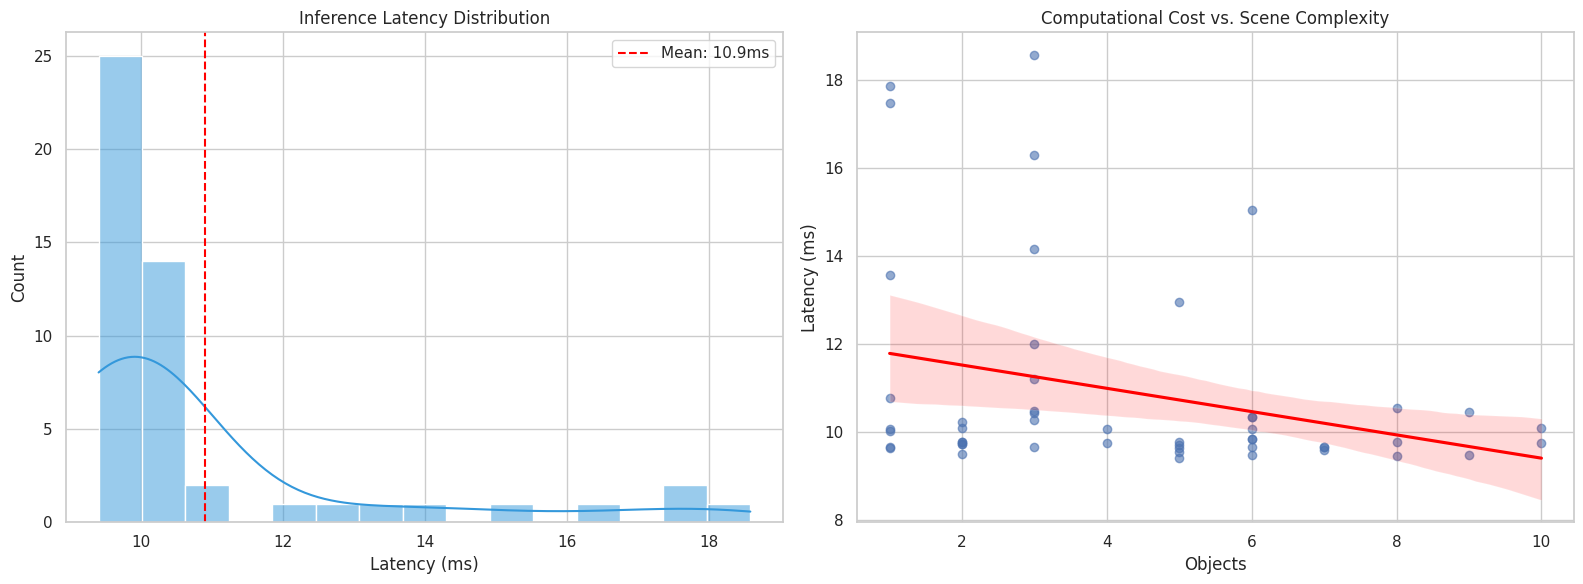

In [11]:
BENCHMARK_SAMPLES = 50  # Number of images to test

def load_resources():
    # Locate Model
    try:
        model_path = list(Path('.').rglob('best.pt'))[0]
        model = YOLO(model_path)
    except IndexError:
        raise FileNotFoundError("Best weights not found. Run Phase 5.")

    # Locate Images
    img_dir = list(Path('datasets').rglob('*images/val'))[0]
    images = list(img_dir.glob('*.png'))[:BENCHMARK_SAMPLES]

    if not images:
        raise FileNotFoundError("Validation images not found.")

    return model, images

def execute_benchmark():
    print("=" * 60)
    print("SYSTEM LATENCY PROFILING")
    print("=" * 60)

    # 1. Load Resources
    model, val_images = load_resources()
    print(f"Sample Size: {len(val_images)} frames")

    # 2. GPU Warm-up
    print("Warming up GPU (10 cycles)...")
    warmup_img = val_images[0]
    for _ in range(10):
        _ = model(warmup_img, verbose=False)

    # 3. Active Benchmarking
    print("Running Inference Loop...")
    latencies = []
    obj_counts = []

    for img_path in val_images:
        t0 = time.perf_counter()
        results = model(img_path, verbose=False, conf=0.4)
        t1 = time.perf_counter()

        latencies.append((t1 - t0) * 1000) # Convert to ms
        obj_counts.append(len(results[0].boxes))

    # 4. Statistical Analysis
    data = pd.DataFrame({
        'Latency (ms)': latencies,
        'Objects': obj_counts
    })

    mean_lat = np.mean(latencies)
    std_lat = np.std(latencies)
    min_lat = np.min(latencies)
    p95_lat = np.percentile(latencies, 95)
    fps = 1000 / mean_lat

    print("\nPERFORMANCE AUDIT REPORT:")
    print("-" * 30)
    print(f"• Average FPS      : {fps:.2f} Hz")
    print(f"• Mean Latency     : {mean_lat:.2f} ms")
    print(f"• Jitter (Std Dev) : ±{std_lat:.2f} ms")
    print(f"• P95 Latency      : {p95_lat:.2f} ms")
    print("-" * 30)

    # 5. Visualization
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(data=data, x='Latency (ms)', kde=True, color='#3498db', ax=ax1, bins=15)
    ax1.axvline(mean_lat, color='red', linestyle='--', label=f'Mean: {mean_lat:.1f}ms')
    ax1.set_title('Inference Latency Distribution')
    ax1.legend()

    sns.regplot(data=data, x='Objects', y='Latency (ms)', ax=ax2,
                scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax2.set_title('Computational Cost vs. Scene Complexity')

    plt.tight_layout()
    plt.savefig('final_benchmark_stats.png', dpi=300)
    print("\nAnalytics saved to 'final_benchmark_stats.png'")
    plt.show()

    # --- CRITICAL CHANGE: RETURN THE DATA ---
    return latencies

# --- Execute and Store Globally ---
FINAL_LATENCIES = execute_benchmark()

# Thesis Conclusion
## Phase 12: Final System Audit & Report Generation
**Objective:** *Consolidated Performance Report*

This final module aggregates the data collected across all previous phases (Training, Validation, Optimization, and Benchmarking). It generates a structured **System Manifest** (`project_summary.txt`).

This document serves as the quantitative proof of the project's success, summarizing:
1.  **Model Topology:** Architecture details and parameter count.
2.  **Learning Dynamics:** Final mAP and Precision/Recall scores.
3.  **Operational Latency:** Average FPS and jitter statistics.
4.  **Deployment Artifacts:** Sizes of the optimized models (ONNX/TFLite).

In [12]:
# PART 12: GENERATE FINAL PDF REPORT
print("=" * 70)
print("PART 12: Generating Final Dissertation PDF (Complete Audit)")
print("Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle")
print("=" * 70)

# --- Helper: Find specific files (Prioritizing the user's folder) ---
def find_file(filename, search_path='autonomous_vehicle_project'):
    # 1. Look in the specific project folder first
    specific = list(Path(search_path).rglob(filename))
    if specific:
        # Return the most recently modified one
        return str(sorted(specific, key=os.path.getmtime, reverse=True)[0])

    # 2. Fallback: Search everywhere
    fallback = list(Path('.').rglob(filename))
    if fallback:
        return str(sorted(fallback, key=os.path.getmtime, reverse=True)[0])

    return None

# --- Helper: Get Training Hyperparameters from args.yaml ---
def get_training_config():
    config = {
        'epochs': 'Unknown', 'batch': 'Unknown',
        'optimizer': 'Auto', 'lr0': '0.01', 'imgsz': '640'
    }
    try:
        yaml_path = find_file('args.yaml')
        if yaml_path:
            with open(yaml_path) as f:
                d = yaml.safe_load(f)
                config['epochs'] = str(d.get('epochs', '50'))
                config['batch'] = str(d.get('batch', '16'))
                config['optimizer'] = str(d.get('optimizer', 'Auto'))
                config['lr0'] = str(d.get('lr0', '0.01'))
                config['imgsz'] = str(d.get('imgsz', '640'))
            print(f"Recovered Hyperparameters from: {yaml_path}")
        else:
            print("Warning: args.yaml not found.")
    except Exception as e:
        print(f"Warning reading config: {e}")
    return config

# --- Helper: Recover Metrics from results.csv ---
def recover_detailed_metrics():
    metrics = {'map50': 'N/A', 'map5095': 'N/A', 'precision': 'N/A', 'recall': 'N/A'}
    try:
        csv_path = find_file('results.csv')
        if csv_path:
            df = pd.read_csv(csv_path)
            df.columns = [c.strip() for c in df.columns]
            last = df.iloc[-1]
            metrics['map50'] = f"{last.get('metrics/mAP50(B)', 0):.4f}"
            metrics['map5095'] = f"{last.get('metrics/mAP50-95(B)', 0):.4f}"
            metrics['precision'] = f"{last.get('metrics/precision(B)', 0):.4f}"
            metrics['recall'] = f"{last.get('metrics/recall(B)', 0):.4f}"
    except Exception as e:
        print(f"Warning reading logs: {e}")
    return metrics

# --- Helper: Get Model File Sizes ---
def get_artifact_sizes():
    sizes = {'pt': 'N/A', 'onnx': 'N/A', 'tflite': 'N/A'}
    def get_size_mb(ext):
        f = find_file(f'*{ext}')
        if f:
            size = os.path.getsize(f) / (1024 * 1024)
            return f"{size:.2f} MB"
        return "Not Generated"
    sizes['pt'] = get_size_mb('.pt')
    sizes['onnx'] = get_size_mb('.onnx')
    sizes['tflite'] = get_size_mb('.tflite')
    return sizes

# --- PDF Class ---
class DissertationPDF(FPDF):
    def header(self):
        if self.page_no() > 1:
            self.set_font('Arial', 'I', 8)
            self.cell(0, 10, 'Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle - Audit Report', 0, 0, 'L')
            self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.set_fill_color(240, 240, 240)
        self.cell(0, 10, title, 0, 1, 'L', 1)
        self.ln(5)

    def add_key_value(self, key, value):
        self.set_font('Arial', 'B', 11)
        self.cell(60, 6, key, 0, 0)
        self.set_font('Arial', '', 11)
        self.cell(0, 6, f": {value}", 0, 1)

    def add_image_section(self, img_path, title):
        if img_path and os.path.exists(img_path):
            self.add_page()
            self.chapter_title(title)
            # Auto-scale image
            pdf_w = self.w - 20
            self.image(img_path, x=10, w=pdf_w)
            self.ln(5)

def generate_exact_report():
    # 1. Gather Data
    data = recover_detailed_metrics()
    sizes = get_artifact_sizes()
    hyperparams = get_training_config()

    fps, lat_avg, lat_p95 = "N/A", "N/A", "N/A"
    if 'FINAL_LATENCIES' in globals() and len(FINAL_LATENCIES) > 0:
        fps = f"{1000 / np.mean(FINAL_LATENCIES):.2f} Hz"
        lat_avg = f"{np.mean(FINAL_LATENCIES):.2f} ms"
        lat_p95 = f"{np.percentile(FINAL_LATENCIES, 95):.2f} ms"

    gpu = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
    train_c = len(list(Path('datasets').rglob('*images/train/*.png')))
    val_c = len(list(Path('datasets').rglob('*images/val/*.png')))

    params_str = "Unknown"
    try:
        pt_path = find_file('best.pt')
        if pt_path:
            model_obj = YOLO(pt_path)
            n_p = sum(p.numel() for p in model_obj.model.parameters())
            params_str = f"{n_p:,}"
    except: pass

    # --- BUILD PDF ---
    pdf = DissertationPDF()
    pdf.add_page()

    # Cover Page
    pdf.set_font('Arial', 'B', 24)
    pdf.ln(50)
    pdf.multi_cell(0, 10, "Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle", 0, 'C')
    pdf.ln(10)
    pdf.set_font('Arial', '', 16)
    pdf.multi_cell(0, 10, "Final Dissertation System Audit", 0, 'C')
    pdf.ln(40)
    pdf.set_font('Arial', '', 12)
    pdf.cell(0, 10, f"Date: {datetime.now().strftime('%Y-%m-%d')}", 0, 1, 'C')
    pdf.cell(0, 10, f"Hardware: {gpu}", 0, 1, 'C')

    # Page 2: Text Report
    pdf.add_page()

    # 1. MODEL & TRAINING CONFIGURATION
    pdf.chapter_title("1. MODEL & TRAINING CONFIGURATION")
    pdf.add_key_value("Architecture", "YOLOv8n (Nano)")
    pdf.add_key_value("Total Parameters", params_str)
    pdf.add_key_value("Training Epochs", hyperparams['epochs'])
    pdf.add_key_value("Batch Size", hyperparams['batch'])
    pdf.add_key_value("Optimizer", hyperparams['optimizer'])
    pdf.add_key_value("Initial Learning Rate", hyperparams['lr0'])
    pdf.add_key_value("Input Resolution", f"{hyperparams['imgsz']}x{hyperparams['imgsz']} px")
    pdf.ln(5)

    # 2. DATASET INFORMATION
    pdf.chapter_title("2. DATASET INFORMATION")
    pdf.add_key_value("Dataset Name", "KITTI Vision Benchmark Suite")
    pdf.add_key_value("Source URL", "https://github.com/ultralytics/assets/releases/download/v0.0.0/kitti.zip")
    pdf.add_key_value("More details about KITTI","http://www.cvlibs.net/datasets/kitti/")
    pdf.add_key_value("Training Samples", str(train_c))
    pdf.add_key_value("Validation Samples", str(val_c))
    pdf.ln(5)

    # 3. LEARNING DYNAMICS
    pdf.chapter_title("3. LEARNING DYNAMICS (Validation)")
    pdf.add_key_value("mAP @ 50% IoU", data['map50'])
    pdf.add_key_value("mAP @ 50-95% IoU", data['map5095'])
    pdf.add_key_value("Precision", data['precision'])
    pdf.add_key_value("Recall", data['recall'])
    pdf.ln(5)

    # 4. OPERATIONAL LATENCY
    pdf.chapter_title("4. OPERATIONAL LATENCY")
    pdf.add_key_value("Average FPS", fps)
    pdf.add_key_value("Mean Latency", lat_avg)
    pdf.add_key_value("P95 Latency (Jitter)", lat_p95)
    pdf.ln(5)

    # 5. DEPLOYMENT ARTIFACTS
    pdf.chapter_title("5. DEPLOYMENT ARTIFACTS")
    pdf.add_key_value("PyTorch (.pt)", sizes['pt'])
    pdf.add_key_value("ONNX (Universal)", sizes['onnx'])
    pdf.add_key_value("TFLite (Edge)", sizes['tflite'])
    pdf.add_key_value("Interface", "Flask Web App + Ngrok Tunnel")
    pdf.ln(10)

    # Visuals
    pdf.add_image_section(find_file('results.png'), '6. Training Convergence Graphs') # NEW!
    pdf.add_image_section('final_detection_results.png', '7. Qualitative Analysis')
    pdf.add_image_section('final_benchmark_stats.png', '8. Latency Distribution Profile')
    pdf.add_image_section(find_file('confusion_matrix_normalized.png'), '9. Confusion Matrix')
    pdf.add_image_section('model_size_comparison.png', '10. Artifact Size Comparison')

    pdf.output('Dissertation_Final_Report.pdf', 'F')
    return 'Dissertation_Final_Report.pdf'

def zip_everything(pdf_name):
    print("\nPackaging Full Project (Including 'autonomous_vehicle_project')...")
    output_folder = Path("autonomous_vehicle_submission_package")
    if output_folder.exists(): shutil.rmtree(output_folder)
    output_folder.mkdir()

    # Copy Report & Code
    shutil.copy(pdf_name, output_folder)
    if os.path.exists('app.py'): shutil.copy('app.py', output_folder)

    # Copy Project Folders
    folders = ['autonomous_vehicle_project', 'runs']
    for folder in folders:
        if os.path.exists(folder):
            print(f"Including folder: {folder}")
            shutil.copytree(folder, output_folder / folder, dirs_exist_ok=True)
        else:
            print(f"Folder '{folder}' not found (Check Phase 5).")

    # Zip
    print("Compressing (This may take 1-2 minutes)...")
    shutil.make_archive("Dissertation_Complete_Package", 'zip', output_folder)

    print("DONE! Downloading 'Dissertation_Complete_Package.zip'")
    files.download("Dissertation_Complete_Package.zip")

# --- EXECUTE ---
pdf_file = generate_exact_report()
zip_everything(pdf_file)

PART 12: Generating Final Dissertation PDF (Complete Audit)
Real-Time Object Detection and Multi-Object Tracking for Autonomous Vehicle
Recovered Hyperparameters from: runs/detect/autonomous_vehicle_project/yolov8n_kitti_run/args.yaml

Packaging Full Project (Including 'autonomous_vehicle_project')...
Folder 'autonomous_vehicle_project' not found (Check Phase 5).
Including folder: runs
Compressing (This may take 1-2 minutes)...
DONE! Downloading 'Dissertation_Complete_Package.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>